Diffusion Botev method for 2d KDE plot


In [1]:
"""
Kernel density estimation via diffusion for 2-dimensional input data.
"""
__license__ = 'MIT'


########################################
# Dependencies                         #
########################################
from numpy import array, arange
from numpy import exp, sqrt, pi as π
from numpy import ceil, log2
from numpy import ones
from numpy import product, outer
from numpy import histogram2d
from scipy.fft import dctn, idctn
from scipy.optimize import brentq


########################################
# Main                                 #
########################################

def kde2d(x, y, n=256, limits=None):
    """
    Estimates the 2d density from discrete observations.
    The input is two lists/arrays `x` and `y` of numbers that represent
    discrete observations of a random variable with two coordinate
    components. The observations are binned on a grid of n×n points,
    where `n` must be a power of 2 or will be coerced to the next one.
    Data `limits` may be specified as a tuple of tuples denoting
    `((xmin, xmax), (ymin, ymax))`. If any of the values are `None`,
    they will be inferred from the data. Each tuple, or even both of
    them, may also be replaced by a single value denoting the upper
    bound of a range centered at zero.
    After binning, the function determines the optimal bandwidth
    according to the diffusion-based method. It then smooths the
    binned data over the grid using a Gaussian kernel with a standard
    deviation corresponding to that bandwidth.
    Returns the estimated `density` and the `grid` (along each of the
    two axes) upon which it was computed, as well as the optimal
    `bandwidth` values (per axis) that the algorithm determined.
    Raises `ValueError` if the algorithm did not converge or `x` and
    `y` are not the same length.
    """

    # Convert to arrays in case lists are passed in.
    x = array(x)
    y = array(y)

    # Make sure numbers of data points are consistent.
    N = len(x)
    if len(y) != N:
        raise ValueError('x and y must have the same length.')

    # Round up number of bins to next power of two.
    n = int(2**ceil(log2(n)))

    # Determine missing data limits.
    if limits is None:
        xmin = xmax = ymin = ymax = None
    elif isinstance(limits, tuple):
        (xlimits, ylimits) = limits
        if xlimits is None:
            xmin = xmax = None
        elif isinstance(xlimits, tuple):
            (xmin, xmax) = xlimits
        else:
            xmin = -xlimits
            xmax = +xlimits
        if ylimits is None:
            ymin = ymax = None
        elif isinstance(ylimits, tuple):
            (ymin, ymax) = ylimits
        else:
            ymin = -ylimits
            ymax = +ylimits
    else:
        xmin = -limits
        xmax = +limits
        ymin = -limits
        ymax = +limits
    if None in (xmin, xmax):
        delta = x.max() - x.min()
        if xmin is None:
            xmin = x.min() - delta/4
        if xmax is None:
            xmax = x.max() + delta/4
    if None in (ymin, ymax):
        delta = y.max() - y.min()
        if ymin is None:
            ymin = y.min() - delta/4
        if ymax is None:
            ymax = y.max() + delta/4
    Δx = xmax - xmin
    Δy = ymax - ymin

    # Bin samples on regular grid.
    (binned, xedges, yedges) = histogram2d(x, y, bins=n,
                                           range=((xmin, xmax), (ymin, ymax)))
    grid = (xedges[:-1], yedges[:-1])

    # Compute discrete cosine transform. Adjust first component.
    transformed = dctn(binned/N)
    transformed[0, :] /= 2
    transformed[:, 0] /= 2

    # Pre-compute squared indices and transform components before solver loop.
    k  = arange(n, dtype='float')          # "float" avoids integer overflow.
    k2 = k**2
    a2 = transformed**2

    # Define internal functions to be solved iteratively.
    def γ(t):
        Σ = ψ(0, 2, t) + ψ(2, 0, t) + 2*ψ(1, 1, t)
        γ = (2*π*N*Σ)**(-1/3)
        return (t - γ) / γ

    def ψ(i, j, t):
        if i + j <= 4:
            Σ  = abs(ψ(i+1, j, t) + ψ(i, j+1, t))
            C  = (1 + 1/2**(i+j+1)) / 3
            Πi = product(arange(1, 2*i, 2))
            Πj = product(arange(1, 2*j, 2))
            t  = (C*Πi*Πj / (π*N*Σ)) ** (1/(2+i+j))
        w = 0.5 * ones(n)
        w[0] = 1
        w = w * exp(-π**2 * k2*t)
        wx = w * k2**i
        wy = w * k2**j
        return (-1)**(i+j) * π**(2*(i+j)) * wy @ a2 @ wx

    # Solve for optimal diffusion time t*.
    try:
        ts = brentq(lambda t: t - γ(t), 0, 0.1)
    except ValueError:
        raise ValueError('Bandwidth optimization did not converge.') from None

    # Calculate diffusion times along x- and y-axis.
    ψ02 = ψ(0, 2, ts)
    ψ20 = ψ(2, 0, ts)
    ψ11 = ψ(1, 1, ts)
    tx1 = (ψ02**(3/4) / (4*π*N*ψ20**(3/4) * (ψ11 + sqrt(ψ02*ψ20))) )**(1/3)
    tx2 = (ψ20**(3/4) / (4*π*N*ψ02**(3/4) * (ψ11 + sqrt(ψ02*ψ20))) )**(1/3)

    # Note:
    # The above uses the nomenclature from the paper. In the Matlab
    # reference, tx1 is called t_y, while tx2 is t_x. This is a curious
    # change in notation. It may be related to the fact that image
    # coordinates are typically in (y,x) index order, whereas matrices,
    # such as the binned histogram (in Matlab as much as in Python),
    # are in (x,y) order. The Matlab code eventually does return
    # image-like index order, though it never explicitly transposes
    # the density matrix. That is implicitly handled by its custom
    # implementation of the inverse transformation (idct2d), which
    # only employs one matrix transposition, not two as its forward
    # counterpart (dct2d).

    # Apply Gaussian filter with optimized kernel.
    smoothed = transformed * outer(exp(-π**2 * k2 * tx2/2),
                                   exp(-π**2 * k2 * tx1/2))

    # Reverse transformation.
    smoothed[0, :] *= 2
    smoothed[:, 0] *= 2
    inverse = idctn(smoothed)

    # Normalize density.
    density = inverse * n/Δx * n/Δy

    # Determine bandwidth from diffusion times.
    bandwidth = array([sqrt(tx2)*Δx, sqrt(tx1)*Δy])

    # Return results.
    return (density, grid, bandwidth)

In [2]:
from numpy.random import normal
x = normal(size=1000000)
y = normal(size=1000000)

In [3]:
(density, grid, bandwidth) = kde2d(x, y, n=100, limits=5)

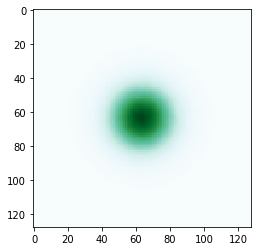

In [5]:
from matplotlib import pyplot as plt
from pylab import *

density_plot=density.T
figure = plt.figure()
axes = figure.add_subplot()
axes.imshow(density_plot)
imshow(density_plot, cmap=cm.BuGn)
plt.show()